In [1]:
import numpy as np
import gymnasium as gym
import torch
import matplotlib.pyplot as plt
from tqdm import trange
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from Networks import *
from PPO_agent import RandomAgent, PPOAgent


### Utility functions ###

In [2]:
def running_average(x, N):
    ''' Function used to compute the running average
        of the last N elements of a vector x
    '''
    if len(x) >= N:
        y = np.copy(x)
        y[N-1:] = np.convolve(x, np.ones((N, )) / N, mode='valid')
    else:
        y = np.zeros_like(x)
    return y

### Initialization ###

In [3]:
# Import and initialize Mountain Car Environment
env = gym.make('LunarLanderContinuous-v2')
# If you want to render the environment while training run instead:
# env = gym.make('LunarLanderContinuous-v2', render_mode = "human")
env.reset()

state_dim = env.observation_space.shape[0] # dimension of state space
action_dim = env.action_space.shape[0] # dimension of action space
max_action = env.action_space.high[0] # max value of action

### Parameters ###

In [42]:
# Parameters
N_episodes = 1600
gamma = 0.99 # Discount factor
actor_lr = 0.00001 # Learning rate
critic_lr = 0.001 # Learning rate
epsilon = 0.2 # Clip parameter
M = 10 # Number of updates per iteration
m = len(env.action_space.high) # dimensionality of the action space


### Training function ###

In [69]:
def random_training(N_episodes, env, m, n_ep_running_average = 50):
    # Reward
    episode_reward_list = []  # Used to save episodes reward
    episode_number_of_steps = []

    # Agent initialization
    agent = RandomAgent(m)

    # Training process
    EPISODES = trange(N_episodes, desc='Episode: ', leave=True)

    for i in EPISODES:
        # Reset enviroment data
        done, truncated = False, False
        state = env.reset()[0]
        total_episode_reward = 0.
        t = 0
        while not (done or truncated):
            # Take a random action
            action = agent.forward(state)

            # Get next state and reward
            next_state, reward, done, truncated, _ = env.step(action)

            # Update episode reward
            total_episode_reward += reward

            # Update state for next iteration
            state = next_state
            t+= 1

        # Append episode reward
        episode_reward_list.append(total_episode_reward)
        episode_number_of_steps.append(t)

        # Updates the tqdm update bar with fresh information
        # (episode number, total reward of the last episode, total number of Steps
        # of the last episode, average reward, average number of steps)
        EPISODES.set_description(
            "Episode {} - Reward/Steps: {:.1f}/{} - Avg. Reward/Steps: {:.1f}/{}".format(
            i, total_episode_reward, t,
            running_average(episode_reward_list, n_ep_running_average)[-1],
            running_average(episode_number_of_steps, n_ep_running_average)[-1]))
        
    return episode_reward_list, episode_number_of_steps


def ppo_training(episodes, env, agent, n_ep_running_average = 50, train=True): 
    episode_reward_list = []  # Used to save episodes reward
    episode_number_of_steps = []

    EPISODES = trange(episodes, desc='Episode: ', leave=True)

    for i in EPISODES:
        # Reset environment data
        done, truncated = False, False
        state = env.reset()[0]
        total_episode_reward = 0.
        agent.clear_trajectory()
        agent.clear_buffer()
        t = 0

        while not (done or truncated):
            action, log_prob = agent.select_action(state)
            next_state, reward, done, truncated, _ = env.step(action)
            agent.store_transition(state, action, reward, next_state, done, log_prob)

            # Update episode reward
            total_episode_reward += reward

            # Update state for next iteration
            state = next_state
            t += 1
        
        # Train the agent
        if train:
            agent.train(i, normal_update=True)

        # Append episode reward
        episode_reward_list.append(total_episode_reward)
        episode_number_of_steps.append(t)

        # Update tqdm progress bar with fresh information
        EPISODES.set_description(
            "Episode {} - Reward/Steps: {:.1f}/{} - Avg. Reward/Steps: {:.1f}/{}".format(
            i, total_episode_reward, t,
            running_average(episode_reward_list, n_ep_running_average)[-1],
            running_average(episode_number_of_steps, n_ep_running_average)[-1]))
    name = f'./weights/neural-network-3-episodes1{agent.gamma}'
    torch.save(agent.actor, name + '-actor'+'.pth')
    torch.save(agent.critic, name + '-critic'+'.pth')
    return episode_reward_list, episode_number_of_steps

In [68]:
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    mps_device = torch.device("mps")

### Testing ###

Episode:   0%|          | 0/1600 [00:00<?, ?it/s]

Episode 1599 - Reward/Steps: 305.1/281 - Avg. Reward/Steps: 185.8/268: 100%|██████████| 1600/1600 [03:18<00:00,  8.04it/s] 


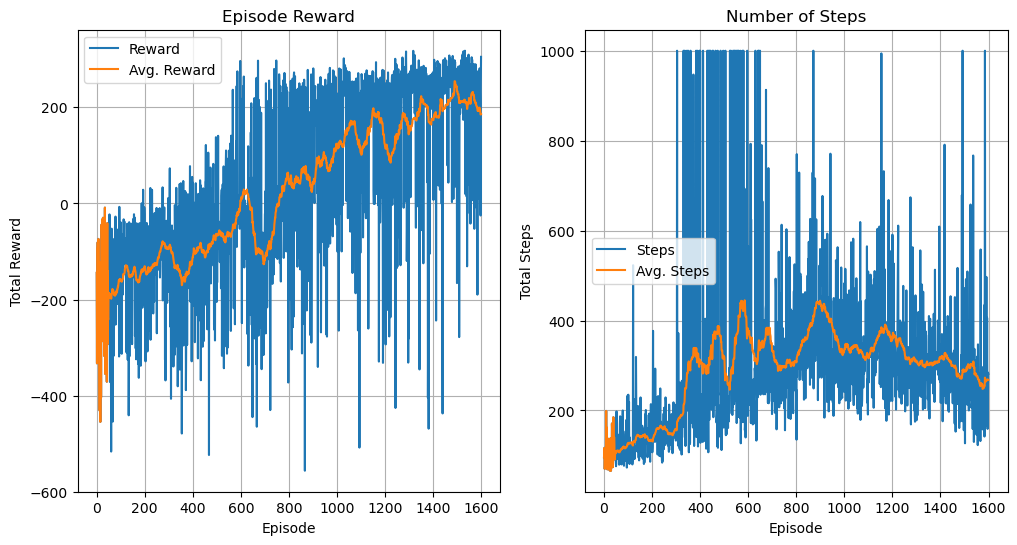

In [58]:
# initialize agent
agent = PPOAgent(state_dim=state_dim, action_dim=action_dim, max_action=max_action, gamma=gamma, actor_lr=actor_lr, critic_lr=critic_lr, epsilon=epsilon, M=M)

# Train the agent
episode_reward_list, episode_number_of_steps = ppo_training(N_episodes, env, agent)

plot_rewards(episode_reward_list, episode_number_of_steps)

In [19]:
# Plot Rewards and steps
def plot_rewards(episode_reward_list, episode_number_of_steps):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(episode_reward_list, label='Reward')
    plt.plot(running_average(episode_reward_list, 50), label='Avg. Reward')
    plt.title('Episode Reward')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(episode_number_of_steps, label='Steps')
    plt.plot(running_average(episode_number_of_steps, 50), label='Avg. Steps')
    plt.title('Number of Steps')
    plt.xlabel('Episode')
    plt.ylabel('Total Steps')
    plt.legend()
    plt.grid()



Testing combination 1/6: {'N_episodes': 1600, 'gamma': 0.99, 'actor_lr': 1e-05, 'critic_lr': 0.001, 'epsilon': 0.01, 'M': 10}


Episode 1599 - Reward/Steps: -82.1/126 - Avg. Reward/Steps: -82.3/511: 100%|██████████| 1600/1600 [03:06<00:00,  8.57it/s]  


Result: -82.33030964666837

Testing combination 2/6: {'N_episodes': 1600, 'gamma': 0.99, 'actor_lr': 1e-05, 'critic_lr': 0.001, 'epsilon': 0.1, 'M': 10}


Episode 1599 - Reward/Steps: 246.9/235 - Avg. Reward/Steps: 205.5/291: 100%|██████████| 1600/1600 [03:06<00:00,  8.58it/s] 


Result: 205.53656948846788

Testing combination 3/6: {'N_episodes': 1600, 'gamma': 0.99, 'actor_lr': 1e-05, 'critic_lr': 0.001, 'epsilon': 0.2, 'M': 10}


Episode 1599 - Reward/Steps: -31.3/190 - Avg. Reward/Steps: 160.6/321: 100%|██████████| 1600/1600 [03:07<00:00,  8.53it/s] 


Result: 160.58525369835309

Testing combination 4/6: {'N_episodes': 1600, 'gamma': 0.99, 'actor_lr': 1e-05, 'critic_lr': 0.001, 'epsilon': 0.4, 'M': 10}


Episode 1599 - Reward/Steps: 257.4/212 - Avg. Reward/Steps: 164.1/230: 100%|██████████| 1600/1600 [02:56<00:00,  9.07it/s] 


Result: 164.09225405193524

Testing combination 5/6: {'N_episodes': 1600, 'gamma': 0.99, 'actor_lr': 1e-05, 'critic_lr': 0.001, 'epsilon': 1, 'M': 10}


Episode 1599 - Reward/Steps: 228.6/270 - Avg. Reward/Steps: 163.9/275: 100%|██████████| 1600/1600 [03:11<00:00,  8.36it/s] 


Result: 163.90070171744784

Testing combination 6/6: {'N_episodes': 1600, 'gamma': 0.99, 'actor_lr': 1e-05, 'critic_lr': 0.001, 'epsilon': 2, 'M': 10}


Episode 1599 - Reward/Steps: 261.5/218 - Avg. Reward/Steps: 185.6/245: 100%|██████████| 1600/1600 [02:48<00:00,  9.51it/s] 


Result: 185.58636136912827

Params: {'N_episodes': 1600, 'gamma': 0.99, 'actor_lr': 1e-05, 'critic_lr': 0.001, 'epsilon': 0.01, 'M': 10}, Performance: -82.33030964666837
Params: {'N_episodes': 1600, 'gamma': 0.99, 'actor_lr': 1e-05, 'critic_lr': 0.001, 'epsilon': 0.1, 'M': 10}, Performance: 205.53656948846788
Params: {'N_episodes': 1600, 'gamma': 0.99, 'actor_lr': 1e-05, 'critic_lr': 0.001, 'epsilon': 0.2, 'M': 10}, Performance: 160.58525369835309
Params: {'N_episodes': 1600, 'gamma': 0.99, 'actor_lr': 1e-05, 'critic_lr': 0.001, 'epsilon': 0.4, 'M': 10}, Performance: 164.09225405193524
Params: {'N_episodes': 1600, 'gamma': 0.99, 'actor_lr': 1e-05, 'critic_lr': 0.001, 'epsilon': 1, 'M': 10}, Performance: 163.90070171744784
Params: {'N_episodes': 1600, 'gamma': 0.99, 'actor_lr': 1e-05, 'critic_lr': 0.001, 'epsilon': 2, 'M': 10}, Performance: 185.58636136912827


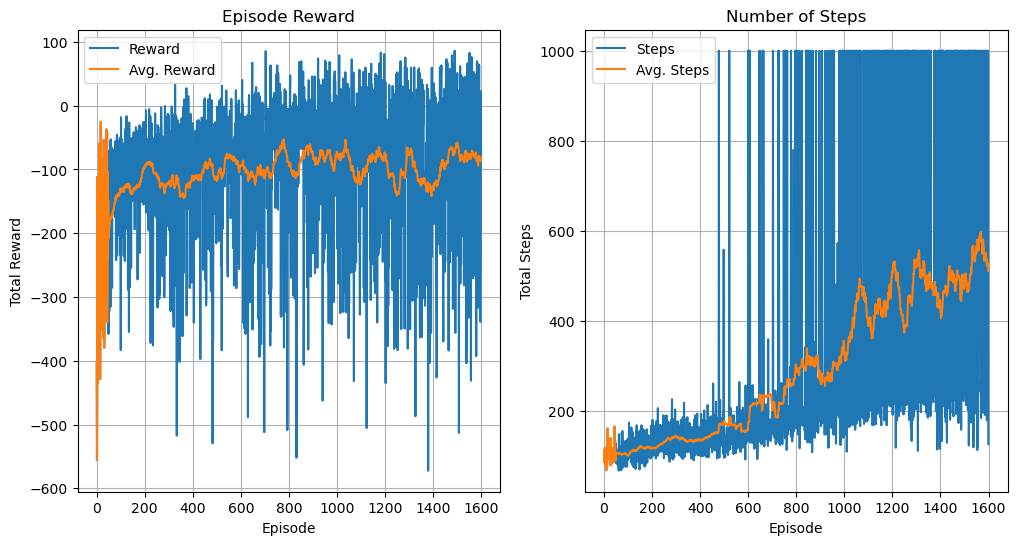

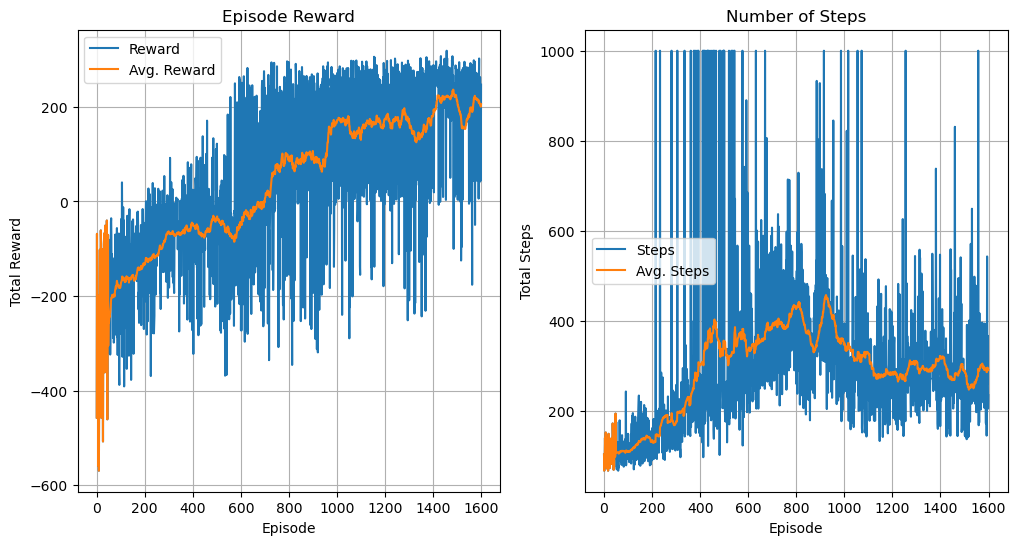

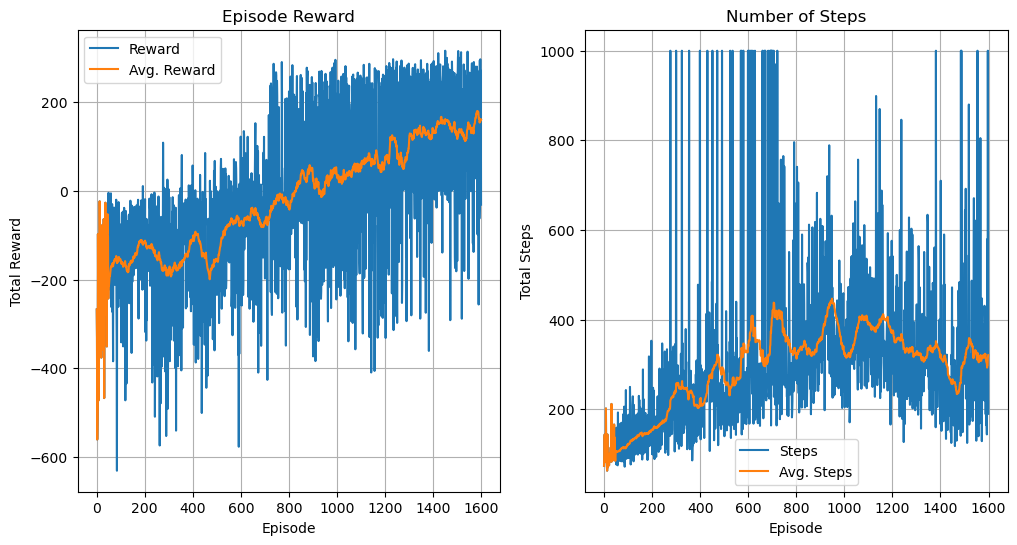

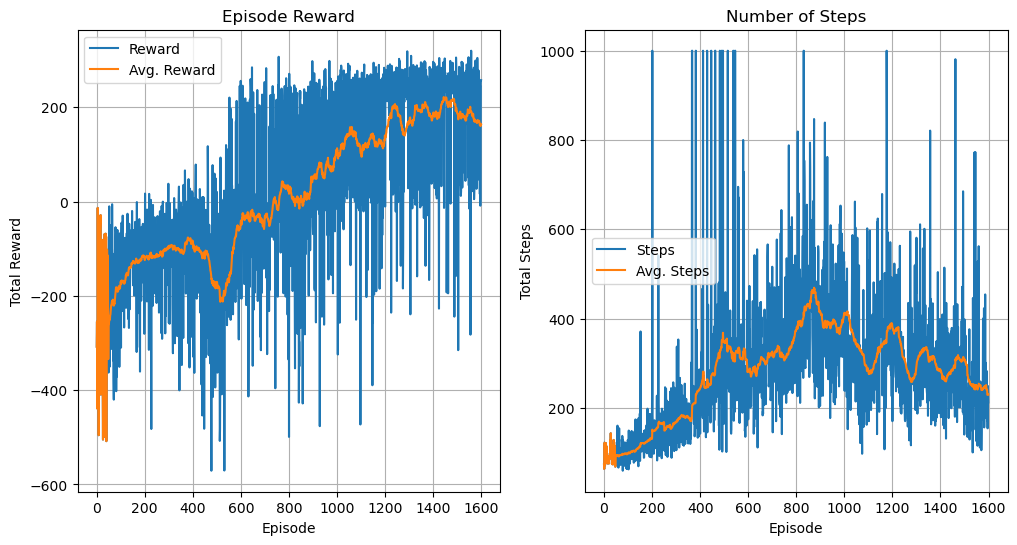

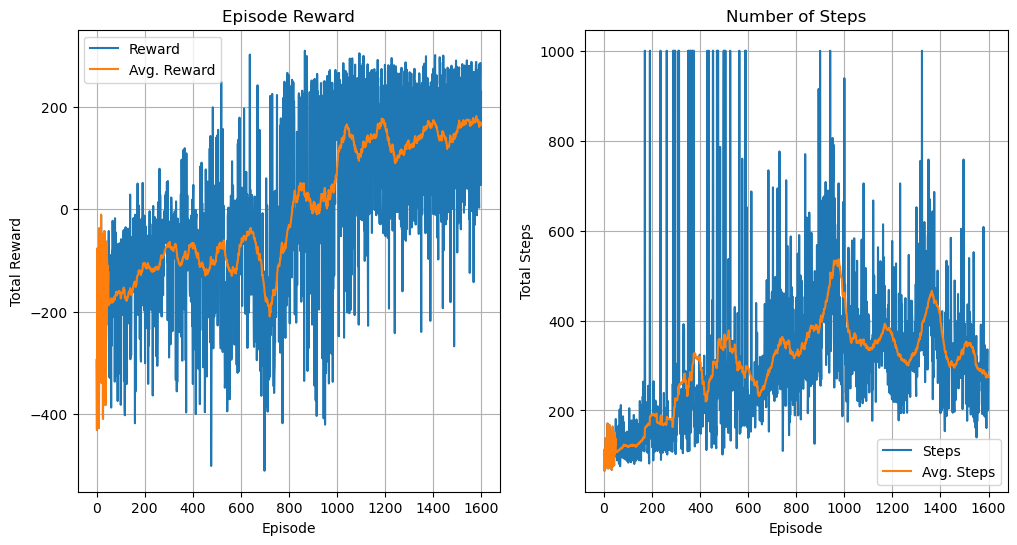

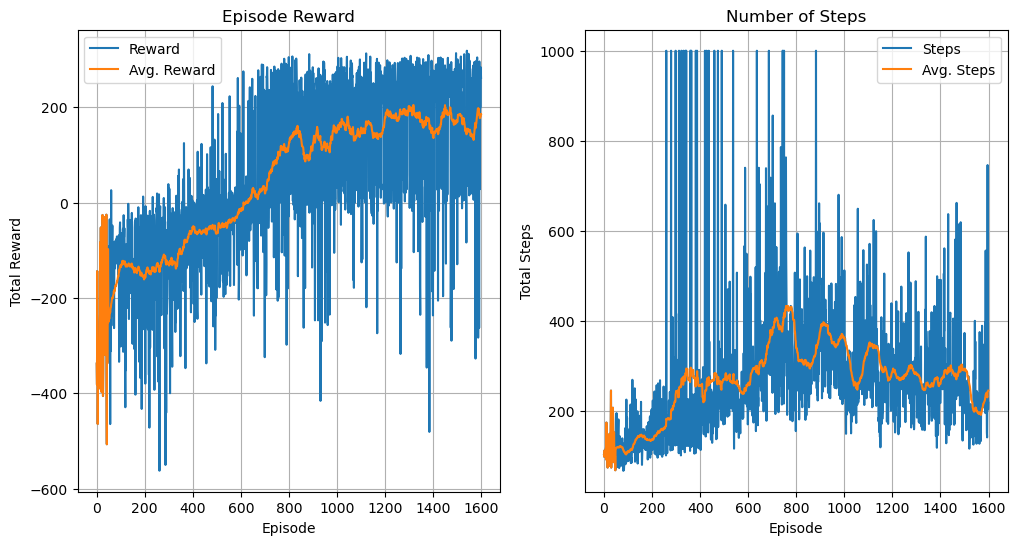

In [26]:
import itertools

def explore_parameters(train_fn, param_grid):
    """
    Explore different hyperparameter combinations and evaluate their performance.

    Args:
        train_fn (function): Function to train the model and return an evaluation metric.
        param_grid (dict): Dictionary of hyperparameters and their possible values.
                           Example: {'gamma': [0.9, 0.95], 'actor_lr': [1e-5, 5e-5]}
    
    Returns:
        results (list): A list of dictionaries containing parameter combinations and their results.
    """
    # Generate all combinations of hyperparameters
    keys = param_grid.keys()
    param_combinations = list(itertools.product(*param_grid.values()))

    results = []

    # Loop over all combinations
    for idx, combination in enumerate(param_combinations):
        # Build a parameter dictionary for the current combination
        params = dict(zip(keys, combination))
        print(f"Testing combination {idx + 1}/{len(param_combinations)}: {params}")

        # Train the model using the given parameters and get performance
        performance = train_fn(**params)

        # Save the results
        result = {'params': params, 'performance': performance}
        results.append(result)

        print(f"Result: {performance}\n")

    return results



# Define the grid of parameters to explore
param_grid = {
    'N_episodes': [1600],
    'gamma': [0.99],
    'actor_lr': [1e-5],
    'critic_lr': [1e-3],
    'epsilon': [0.01, 0.1, 0.2, 0.4, 1, 2],
    'M': [10]
}

def performance_test(N_episodes, gamma, actor_lr, critic_lr, epsilon, M):
    # Train the agent
    agent = PPOAgent(state_dim=state_dim, action_dim=action_dim, max_action=max_action, gamma=gamma, actor_lr=actor_lr, critic_lr=critic_lr, epsilon=epsilon, M=M)
    episode_reward_list, episode_number_of_steps = ppo_training(N_episodes, env, agent)
    plot_rewards(episode_reward_list, episode_number_of_steps)
    return np.mean(episode_reward_list[-50:])

# Run parameter exploration
results = explore_parameters(performance_test, param_grid)

# Print all results
for res in results:
    print(f"Params: {res['params']}, Performance: {res['performance']}")


Testing combination 180/1200: {'N_episodes': 400, 'gamma': 0.9, 'actor_lr': 1e-05, 'critic_lr': 0.001, 'epsilon': 0.4, 'M': 20}
Episode 399 - Reward/Steps: -76.2/140 - Avg. Reward/Steps: -114.5/107: 100%|██████████| 400/400 [00:34<00:00, 11.53it/s] 
Result: -114.52562178266793



In [97]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



def plot_value_function(agent, y_range, omega_range):
    """
    Plots the value function Vω(s(y, ω)) for varying y and ω.
    
    Args:
        agent: The PPOAgent containing the CriticNetwork.
        y_range: A tuple (y_min, y_max) specifying the range of y.
        omega_range: A tuple (omega_min, omega_max) specifying the range of ω.
    """
    y_vals = np.linspace(y_range[0], y_range[1], 100)
    omega_vals = np.linspace(omega_range[0], omega_range[1], 100)
    Y, Omega = np.meshgrid(y_vals, omega_vals)
    
    V = np.zeros_like(Y)
    
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            state = torch.tensor([[0, Y[i, j], 0, 0, Omega[i, j], 0, 0, 0]], dtype=torch.float32)
            V[i, j] = agent.critic(state).item()

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(Omega, Y, V, cmap='viridis')
    ax.set_ylabel('Height (y)')
    ax.set_xlabel('Angle (ω)')
    ax.set_zlabel('Value Function $V_ω(s)$')
    ax.set_title('Value Function $V_ω(s(y, ω))$')
    plt.show()

Network model: ActorNetwork(
  (shared_layer): Sequential(
    (0): Linear(in_features=8, out_features=400, bias=True)
    (1): ReLU()
  )
  (mu_head): Sequential(
    (0): Linear(in_features=400, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=2, bias=True)
    (3): Tanh()
  )
  (sigma_head): Sequential(
    (0): Linear(in_features=400, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=2, bias=True)
    (3): Sigmoid()
  )
)
Network model: CriticNetwork(
  (network): Sequential(
    (0): Linear(in_features=8, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=1, bias=True)
  )
)


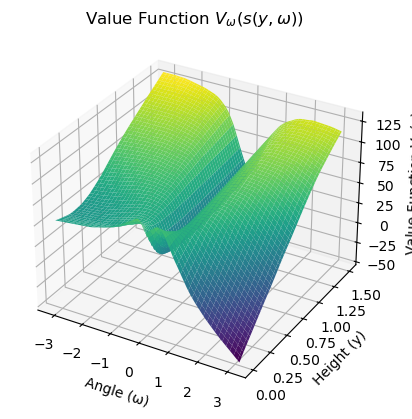

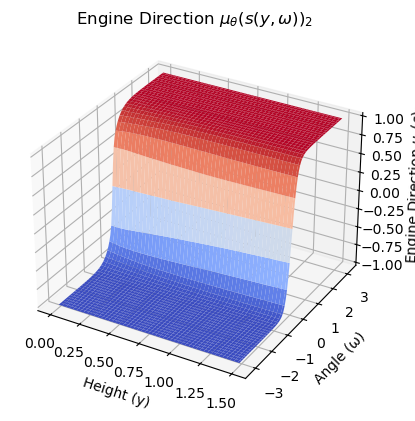

In [98]:
def plot_engine_direction(agent, y_range, omega_range):
    """
    Plots the engine direction μθ(s(y, ω))_2 for varying y and ω.
    
    Args:
        agent: The PPOAgent containing the ActorNetwork.
        y_range: A tuple (y_min, y_max) specifying the range of y.
        omega_range: A tuple (omega_min, omega_max) specifying the range of ω.
    """
    y_vals = np.linspace(y_range[0], y_range[1], 100)
    omega_vals = np.linspace(omega_range[0], omega_range[1], 100)
    Y, Omega = np.meshgrid(y_vals, omega_vals)
    
    Mu = np.zeros_like(Y)
    
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            state = torch.tensor([[0, Y[i, j], 0, 0, Omega[i, j], 0, 0, 0]], dtype=torch.float32)
            mu, _ = agent.actor(state)
            Mu[i, j] = mu[0, 1].item()  # Second component of the mean action

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(Y, Omega, Mu, cmap='coolwarm')
    ax.set_xlabel('Height (y)')
    ax.set_ylabel('Angle (ω)')
    ax.set_zlabel('Engine Direction $μ_θ(s)_2$')
    ax.set_title('Engine Direction $μ_θ(s(y, ω))_2$')
    plt.show()


# Example usage
y_range = (0, 1.5)
omega_range = (-np.pi, np.pi)

loaded = True
try:
    model_actor = torch.load('neural-network-3-actor.pth')
    print('Network model: {}'.format(model_actor))
except:
    print('File neural-network-3-actor.pth not found!')
    exit(-1)

try:
    model_critic = torch.load('neural-network-3-critic.pth')
    print('Network model: {}'.format(model_critic))
except:
    print('File neural-network-3-critic.pth not found!')
    exit(-1)

if loaded:
    agent = PPOAgent(state_dim=state_dim, action_dim=action_dim, max_action=max_action, gamma=gamma, actor_lr=actor_lr, critic_lr=critic_lr, epsilon=epsilon, M=M)
    agent.actor = model_actor
    agent.critic = model_critic

plot_value_function(agent, y_range, omega_range)
plot_engine_direction(agent, y_range, omega_range)

Network model: ActorNetwork(
  (shared_layer): Sequential(
    (0): Linear(in_features=8, out_features=400, bias=True)
    (1): ReLU()
  )
  (mu_head): Sequential(
    (0): Linear(in_features=400, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=2, bias=True)
    (3): Tanh()
  )
  (sigma_head): Sequential(
    (0): Linear(in_features=400, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=2, bias=True)
    (3): Sigmoid()
  )
)
Network model: CriticNetwork(
  (network): Sequential(
    (0): Linear(in_features=8, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=1, bias=True)
  )
)


Episode 49 - Reward/Steps: 237.1/294 - Avg. Reward/Steps: 259.3/302: 100%|██████████| 50/50 [00:03<00:00, 14.35it/s]
Episode 49 - Reward/Steps: -387.4/119 - Avg. Reward/Steps: -181.9/106: 100%|██████████| 50/50 [00:00<00:00, 193.03it/s]


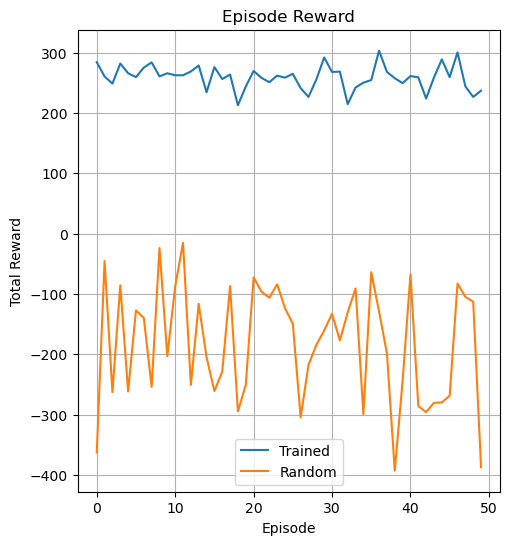

In [ ]:
# Plot the reward over 50 episodes using the trained agent
try:
    model_actor = torch.load('neural-network-3-actor.pth')
    print('Network model: {}'.format(model_actor))
except:
    print('File neural-network-3-actor.pth not found!')
    exit(-1)

try:
    model_critic = torch.load('neural-network-3-critic.pth')
    print('Network model: {}'.format(model_critic))
except:
    print('File neural-network-3-critic.pth not found!')
    exit(-1)

agent = PPOAgent(state_dim=state_dim, action_dim=action_dim, max_action=max_action, gamma=gamma, actor_lr=actor_lr, critic_lr=critic_lr, epsilon=epsilon, M=M)  
agent.actor = model_actor
agent.critic = model_critic

episode_reward_list_trained, episode_number_of_steps_trained = ppo_training(50, env, agent, train=False)
episode_reward_list_random, episode_number_of_steps_random = random_training(50, env, m)

#Plot both rewards
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(episode_reward_list_trained, label='Trained')
plt.plot(episode_reward_list_random, label='Random')
plt.title('Episode Reward')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid()


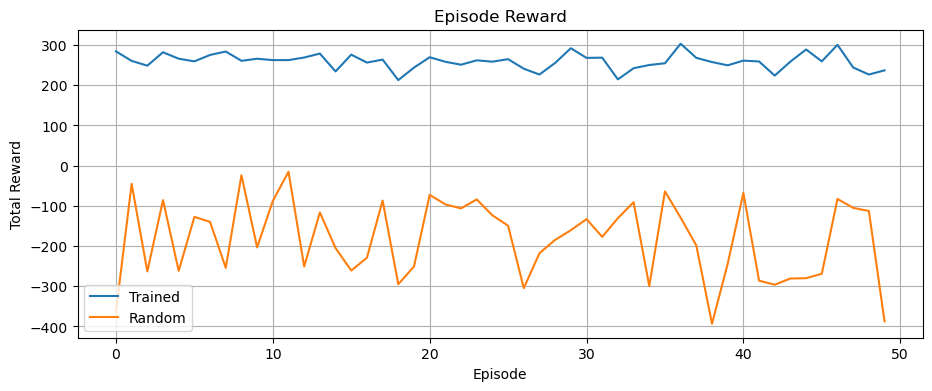

In [83]:
plt.figure(figsize=(24, 4))
plt.subplot(1, 2, 1)
plt.plot(episode_reward_list_trained, label='Trained')
plt.plot(episode_reward_list_random, label='Random')
plt.title('Episode Reward')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid()